# **Part 2 - Granger causal effect of Google Trends on BTC**

## **1. Introduction**

💯 **Goal:** 

The objective of this second part is to start from a collection of keywords and retrieve their respective *Google Trends index* over the studied period. The chosen keywords are the following : 
> Bitcoin, btc, btc price, crypto, cryptocurrency, trading, coinbase, blockchain, binance, China, FED, Musk

Our methodology involves a comprehensive examination of each individual keyword and all possible bigrams formed from these keywords. For each bigram, we aggregate the individual Google Trends indexes by calculating the mean.

Subsequently, Granger causality tests are conducted for each keyword combination, aiming to determine whether the Google Trends index significantly influences the prediction of Bitcoin's key indicators—log returns, volatility, and volume—at various time lags. This step allows us to identify keywords and bigrams with a substantial impact on Bitcoin's price dynamics.

With the obtained results, we conduct a thorough analysis of the influence of market sentiment, measured by the popularity of our selected keywords, on Bitcoin's key indicators. Key questions we aim to address include whether volatility, volume, and log returns of Bitcoin exhibit similar reactions to market sentiment, whether specific keywords are linked to these indicators, and whether certain keywords have a more immediate impact on Bitcoin's price dynamics.


Using these results, we will be able to pursue a deeper analysis of the impact of market sentiment, gauged by the popularity of our keywords, on the selected Bitcoin's indicators. We will answer the following questions. 
> Do volatility, volume, and log returns exhibit similar reactions to market sentiment ? Are specific keywords linked to these indicators ? Do certain keywords have a shorter-term impact on Bitcoin's price dynamics than others ? 

Upon completing this analysis, we further quantify the identified impact by computing the mutual information between keywords that granger cause Bitcoin's key indicators. This information will enable us to rank the keywords based on their significance in influencing Bitcoin's price dynamics.

In [5]:
import pandas as pd
import numpy as np
import dask 

import matplotlib.pyplot as plt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import seaborn as sns

from datetime import datetime, date
import time

import yfinance as yf

from pytrends.request import TrendReq

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests

import os
import glob
import pprint as pp
from itertools import combinations

import warnings
warnings.filterwarnings("ignore")

## **2. Data collection**

### **Get Google Trends data**

To get a first overview of the market sentiment towards BTC, our first idea is to study the impact of the Google Trends *"Interest over time"* index in predicting variations of Bitcoin.

**The Google Trends Interest over time index**, ranging from 0 to 100, serves as a metric indicating the popularity of a keyword on the Internet. It is derived from the frequency of Google searches related to a specific term. Higher values signify increased interest.

To obtain the Google Trends indices for our analysis, we conducted a series of API calls to the Google Trends API. We had to design a method  to select the right timeframe, ensuring the acquisition of daily data. Indeed, beyond a specific threshold, the data undergoes aggregation on a weekly or monthly basis—an outcome that diverges from our research objective. 

💡 While our current analysis centers on daily data to provide an encompassing overview of market sentiment, we will later use this code to focus on specific periods by using intraday data, enabling a more focused exploration of specific time periods for a comprehensive understanding of Bitcoin market dynamics.  

🚨 **Data normalization**   

Unfortunately, Google Trends does not offer normalized data. For each selected timeframe, values will be scaled so that one date will have a score of 100 within the requested timeframe. 
This means that the values are relative to the highest point on the chart for the given timeperiod and concatening the results will give inconsistent results when comparing different time periods. 

Thus, we decided to normalize the data by multiplying each timeframe by a constant factor $c$, calculated as follows : $c = \frac{x_{t-1, l}}{x_{t,f}}$, where $x_{t-1, l}$ is the last value of the index for the previous timeframe and $x_{t, f}$ time is the first value of the index for the current time period. 

Note that the timeframes were computed in such a way that they overlapped by one day. Therefore, $x_{t-1, l}$ and $x_{t, f}$ are the values of the index for the same date. Hence, we would have $ {x'_{t,f}} = {x_{t,f}} * c = {x_{t,f}} * \frac{x_{t-1, l}}{x_{t,f}} = x_{t-1, l}$, and the values will be consistent across all the studied time period. 

Last but not least, we added some computations in case one of $x_{t-1, l}$ and $x_{t, f}$ wereequal to 0. Otherwise, all values of the current dataframe would be equal to 0 when multiplying by $c$.

In [18]:
@dask.delayed
def get_google_trends_data_one_timeframe(kw_list, timeframe) :
    """Scrap data from Google Trends to get daily interest rates for a given list of keywords over a specific timeframe.""" 

    # Connect to Google
    pytrends = TrendReq(hl='en-US', tz=360)

    #Build payload
    pytrends.build_payload(kw_list=kw_list, timeframe=timeframe)
    df = pytrends.interest_over_time()
    df.drop(columns=['isPartial'], inplace=True)

    return df 

def get_google_trends_data(kw_list, start_date, end_date) :
    """Scrap data from Google Trends to get daily interest rates for a given list of keywords for a desired time period."""

    #Create timeframes of 6 months from start_date to end_date 
    #Careful, we put one day overlap between each timeframe to normalize data. 
    years = [i for i in range(start_date.year, end_date.year+1)]

    timeframes = []
    for year in years : 
        timeframes.append(f"{year}-01-01 {year}-07-02")
        if year != end_date.year :
            timeframes.append(f"{year}-07-01 {year+1}-01-02")
        else :
            timeframes.append(f"{year}-07-01 {end_date.year}-{end_date.month}-{end_date.day}")
    
    #Make API requests on each timeframe and concatenate the results
    allpromises = [get_google_trends_data_one_timeframe(kw_list, timeframe) for timeframe in timeframes]
    alldata=dask.compute(allpromises)[0]

    #Normalize data
    res = []
    for index, kw in enumerate(kw_list) :
        data = normalize_data(alldata, kw, index)
        res.append(data)
    
    #Concatenate dataframes
    alldata = pd.concat(res, axis=1)

    return alldata    

def normalize_data(data, col_name, index) :
    """Normalize data by multiplying each value of a specific timeframe by the ratio 
    of the last value of the previous timeframe and the first value of the current timeframe."""

    #Order list of dataframes by date based on index of first row 
    data = [data[i] for i in np.argsort([data[i].index[0] for i in range(len(data))])]

    #Only keep the column of interest
    data = [df[[col_name]] for df in data]

    #List to store the normalized dataframes
    new_data = []

    #Store previous timeframe
    previous_df = data[0]

    for current_df in data[1:] :

        #Retrieve value of index for last day (previous df)
        previous_val = previous_df.iloc[-1,:].item()

        #We don't want a null value, otherwise all values of the normalized dataframe will be null
        cpt = -2
        try : 
            while previous_val == 0 :
                previous_val = previous_df.iloc[cpt,:].item()
                cpt -= 1
        except :
            previous_val = 1

        #Retrieve value of index for first day (current df)
        current_val = current_df.iloc[0,:].item()

        #Same as before, we don't want a null value
        cpt = 1
        try : 
            while current_val == 0 :
                current_val = current_df.iloc[cpt,:].item()
                cpt += 1
        except :
            current_val = 1
        
        #Normalize current df
        current_df = current_df * (previous_val / current_val)

        #Append to list
        new_data.append(current_df)

        #Update previous df
        previous_df = current_df

    #Concatenate dataframes
    data = pd.concat(new_data, axis=0)

    return data


def main_google_trends() :
    """Main function to call for collecting data from Google Trends. Note that the length of keywords is limited to 5."""
    start_date = date(year=2019, month=1, day=1)
    end_date = datetime.today()

    kw_list = [ "Bitcoin", "btc", "btc price", "crypto", "cryptocurrency", 
                "trading", "coinbase", "blockchain", "binance",
                "China", "FED", "Musk"]
    
    #Split keywords into lists of 5 keywords
    kw_lists = np.array_split(kw_list, np.ceil(len(kw_list) / 5))

    save_dir = "data/raw/google_trends/"
    
    df_list = []
    for kw in kw_lists :
        print("Collecting data for keywords : ", kw)
        data = get_google_trends_data(kw, start_date, end_date)
        time.sleep(10)
        df_list.append(data)

    df = pd.concat(df_list, axis=1)

    #Save file 
    if not os.path.isdir(save_dir):
        os.makedirs(save_dir)
    name_file = "interest_index"

    df.to_parquet(save_dir+name_file+".parquet", use_deprecated_int96_timestamps=True, compression="brotli")

In [29]:
%timeit 
#main_google_trends()

#### **First analysis**

💡 Let's visualize how each index varies over time to get a quick idea of the data we are dealing with.

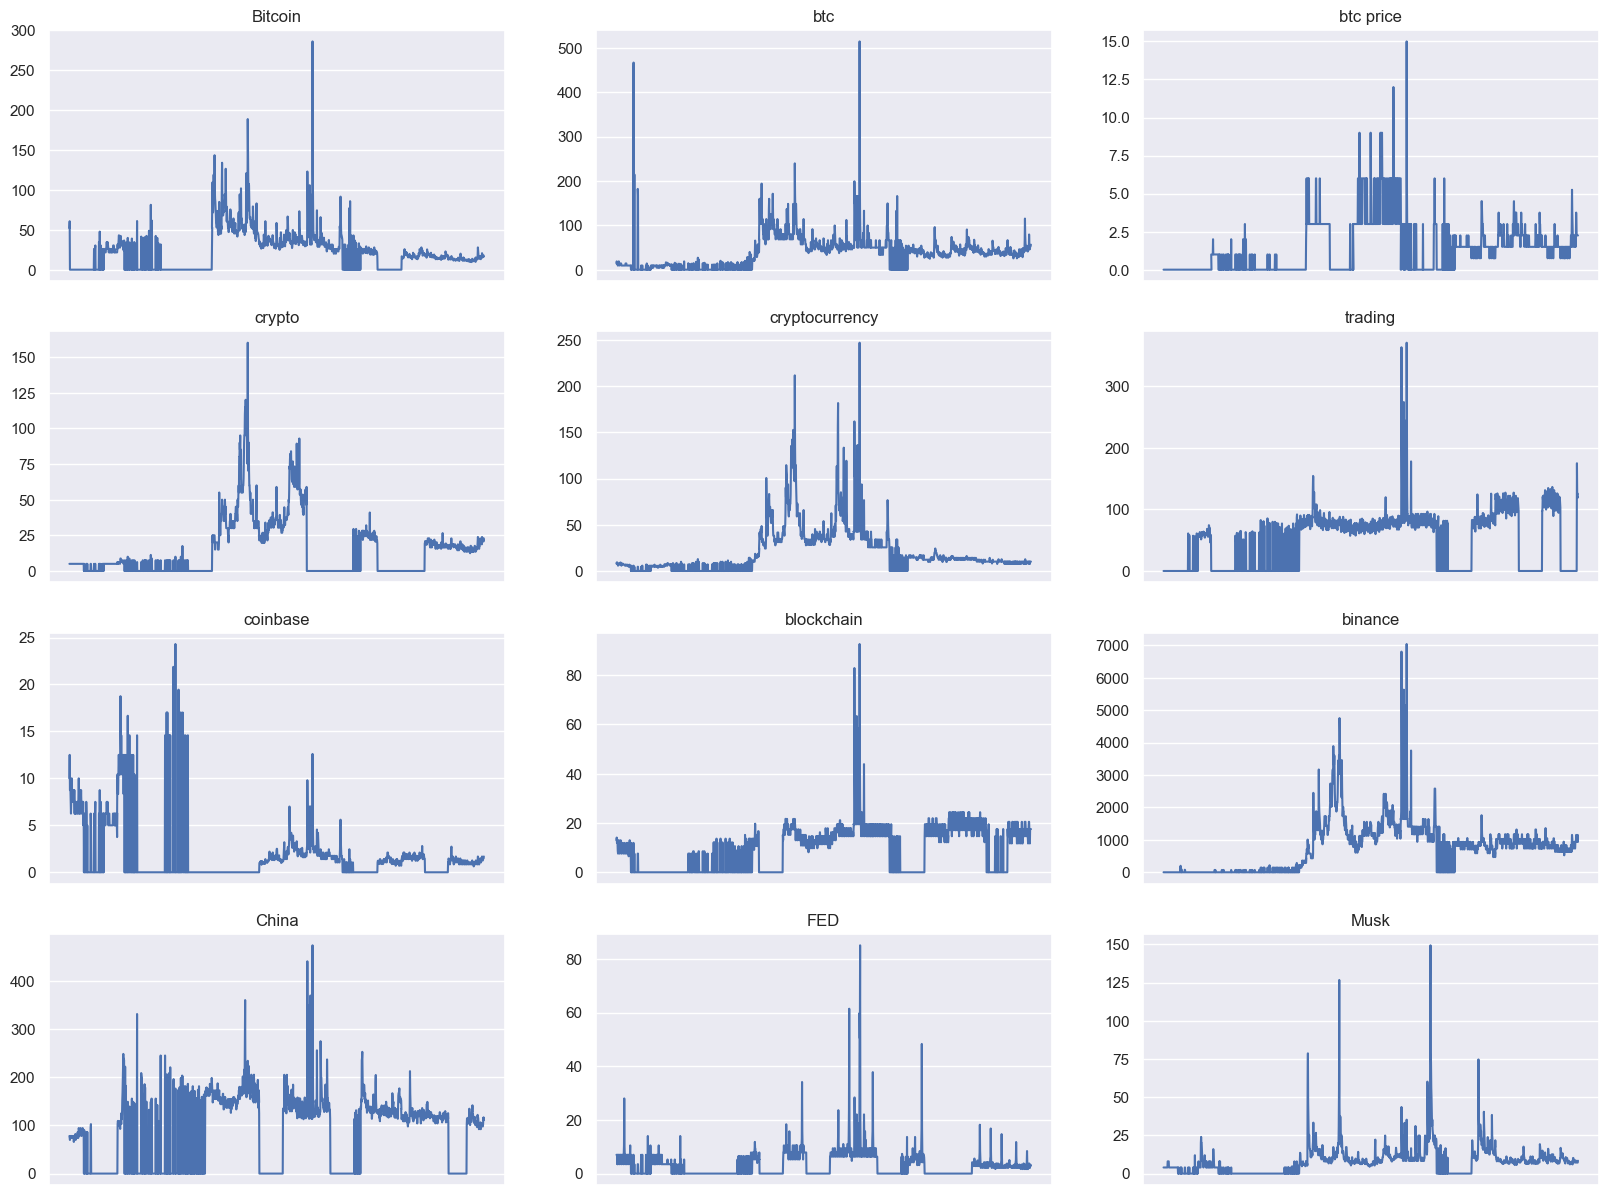

In [31]:
gt = pd.read_parquet("data/raw/google_trends/interest_index.parquet")

fig, axs = plt.subplots(4, 3, figsize=(20, 15), sharex=True)

for i, ax in enumerate(axs.flatten()) :
    ax.plot(gt.iloc[:,i])
    ax.set_title(gt.columns[i])
    ax.set_xticks([])
plt.show()

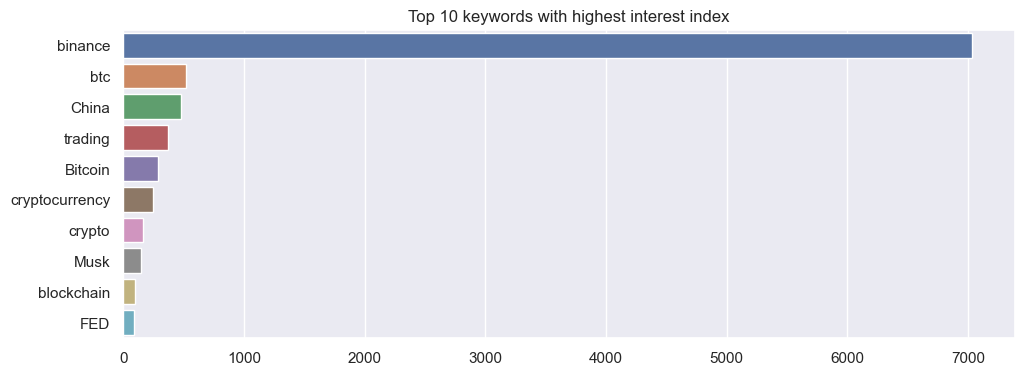

In [32]:
#Rank keywords by max value of interest index
gt_max = gt.max(axis=0).sort_values(ascending=False)

#Plot top 10 keywords 
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.5,4)})
ax = sns.barplot(x=gt_max[:10].values, y=gt_max[:10].index, orient="h")
ax.set_title("Top 10 keywords with highest interest index", fontsize=12)
plt.show()

✍🏻 Please note that the y-scale varies across each subplot. Notably, the keywords "Binance" and "Bitcoin" exhibit the highest interest scores, with "Binance" reaching approximately 7000. Conversely, certain keywords like "BTC price" or "coinbase", appear to have lower interest, prompting our decision to exclude them from further analysis.

As anticipated, the patterns of the interest index for specific keywords closely mirror the price dynamics of Bitcoin, with an exponentially looking trend up to mid-2021, followed by a U-shaped curve. This trend is particularly evident in the case of "btc" and "binance" keywords.

These first visualizations are encouraging, as they suggest that the Google Trends index could be a good predictor of Bitcoin's key indicators. However, we will need to conduct a more thorough analysis to confirm this hypothesis.

In [33]:
#Remove less popular keywords
gt.drop(columns=["coinbase", "btc price"], axis=1, inplace=True)

#### **Combination of keywords**

💡 We create a list comprising each individual keyword and all possible bigrams formed from these keywords. This strategic move towards a brute-force method to identify keywords and pair of keywords that could contribute to predicting Bitcoin's price in a statistically significant manner. We create an aggregated index using the mean for bigrams.

In [34]:
def combinations_keywords(kw_list) : 
    """Get all possible combinations of keywords."""
    all_combinations = []
    for r in range(1, 3):
        all_combinations.extend(list(comb) for comb in combinations(kw_list, r))
    return all_combinations

comb_kw = combinations_keywords(gt.columns)
print(len(comb_kw))

55


### **Get BTC daily data**

In [242]:
def get_daily(gt, start) :
    """
    Get historical daily price from Yahoo Finance API. 
    Prepare data for Granger Causality test.
    """ 
    ticker = yf.Ticker("BTC-USD")
    df = ticker.history(start=start)

    #Logreturns 
    df['Logrets'] = np.log(df['Close']).diff()
    df.dropna(inplace=True)

    #Volatility 
    df['Volatility'] = df["Logrets"].rolling(3).std()
    df.dropna(inplace=True)

    #Keep index within range of Google Trends data
    min_gt = gt.index.min()
    max_gt = gt.index.max()
    df = df[df.index.date >= min_gt.date()]
    df = df[df.index.date <= max_gt.date()]

    #Set index to datetime
    df.index = df.index.date

    return df[['Logrets', 'Volatility', 'Volume']]

btc = get_daily(gt, start="2018-12-15")

### **Merge dataFrames**

In [36]:
@dask.delayed
def merge_btc_gt_one_file(btc, gt, kw_list, dest_dir) :
    """
    Retrieve columns from kw_list, compute aggregated indexes (if needed). 
    Merge crypto historical data and aggregated Google Trends data. 
    Save results to file. 
    """
    gt = gt[kw_list]
    
    #Compute aggregated index 
    if len(kw_list) > 1 :
        gt["Index_mean"] = gt.mean(axis=1)
        gt.drop(columns=kw_list, inplace=True)

    #Merge
    crypto_gt = btc.merge(gt, how="right", left_index=True, right_index=True)

    #Save as parquet 
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir)

    name_file = "_".join(kw_list)
    crypto_gt.to_parquet(dest_dir+name_file, use_deprecated_int96_timestamps=True, compression="brotli")

def merge_btc_gt(btc, gt, comb_kw) :
    """
    Main function to call for merging BTC daily and Google Trends data. 
    """
    dest_dir = "data/clean/google_trends/"

    allpromises=[merge_btc_gt_one_file(btc, gt, kw_list, dest_dir) for kw_list in comb_kw]
    alldata=dask.compute(allpromises)[0]

merge_btc_gt(btc, gt, comb_kw)

## **3. Granger causality test**

Granger causality, introduced by Clive Granger, examines whether past values of one time series variable  $X_t$ can improve the prediction of another $Y_t$. Denoted as $X_t$ Granger-causing $Y_t$, the concept is expressed through statistical tests, such as the Granger causality test.

The Granger causality test involves comparing the predictive performance of two models: one that includes the lagged values of both variables (the complete model) and another that excludes the lagged values of the supposed causing variable (the reduced model).

*Reduced Model (Without $X_t$):*
   $Y_t = \sum_{i=1}^{p} \beta_i Y_{t-i} + \varepsilon_t $

*Complete Model (With $X_t$):*
   $Y_t = \sum_{i=1}^{p} \beta_i Y_{t-i} + \sum_{j=1}^{q} \gamma_j X_{t-j} + \varepsilon_t $

*F-Statistic for Granger Causality Test:*
   $ F = \frac{\frac{{\text{RSS}_{\text{reduced}} - \text{RSS}_{\text{complete}}}}{q}}{{\frac{\text{RSS}_{\text{complete}}}{(n - p - q - 1)}}} $
where:
- $\text{RSS}_{\text{reduced}} $ is the residual sum of squares from the reduced model,
- $ \text{RSS}_{\text{complete}} $ is the residual sum of squares from the complete model,

While not implying a direct cause-and-effect relationship, Granger causality provides valuable insights into predictive patterns, contributing to a nuanced understanding of dynamic systems over time.

### **Prepare data for Granger causality test**

**Granger causality test** is carried out only on stationary data hence we first need to check if data is stationary.

**ADF test** is a popular statistical test for checking whether the Time Series is stationary or not which works based on the unit root test. 

- *Null Hypothesis (H0):* Series has a unit root and is non-stationary.
- *Alternative Hypothesis (H1):* Series has no unit root and is stationary.

First, we check if logreturns, volatility and volume are stationary (which should be the case for the first two). It will avoid us to make the test for each file.

In [37]:
def is_stationary(df, col_name):
    result = adfuller(df[col_name])
    return result[1] < 0.05

#Open an arbitrary file 
test = pd.read_parquet("data/clean/google_trends/btc")
print(f"Logrets stationary?\t{is_stationary(test, 'Logrets')}")
print(f"Volatility stationary?\t{is_stationary(test, 'Volatility')}")
print(f"Volume stationary?\t{is_stationary(test, 'Volume')}")      

Logrets stationary?	True
Volatility stationary?	True
Volume stationary?	True


💡The three indicators are stationary. We can continue the analysis. 

Next, we create a set of functions that first test if the data is stationary. If it is not the case, we differentiate the time series once and test again. We skip the test if the data is not stationary after the first differentiation.

In [38]:
def differentiate(df, col_name) : 
    """
    Differentiate a time series to attempt to make it stationary.
    If the time series is not stationary after differentiation, return None.
    """
    df[col_name] = df[col_name].diff()
    df.dropna(subset=[col_name], inplace=True)
    return None if not is_stationary(df, col_name) else df 

def check_and_drop_nonstationary(df, col_name) :
    """
    Check if a time series is stationary and call differentiate() if not.
    """
    return df if is_stationary(df, col_name) else differentiate(df, col_name)

@dask.delayed
def prepare_data_one_file(path_file) :
    """
    Prepare data for Granger Causality test.
    """

    #Retrieve name of the file
    dir_name = "data/clean/google_trends\\"
    file_name = path_file.replace(dir_name, "")

    #Retrieve data
    df = pd.read_parquet(path_file)

    #Check if data is stationary and differentiate if not
    df = check_and_drop_nonstationary(df, df.columns[-1])   

    #If data is still not stationary, drop the file
    if (df is None and os.path.exists(path_file)):
        print(f"{file_name} removed.")
        os.remove(path_file)

def prepare_data() :
    """
    Main function to call for preparing data for Granger Causality test.
    """
    allfiles = glob.glob("data/clean/google_trends/*")
    allpromises=[prepare_data_one_file(path_file) for path_file in allfiles]
    alldata=dask.compute(allpromises)[0]

In [39]:
prepare_data()

### **Granger causality test**

With all the time series now rendered stationary, our focus turns to investigating potential Granger causality relationships between an aggregated keyword index and one of the three Bitcoin indicators we have selected.

**Granger Causality Test Framework:**

- *Null Hypothesis (H0)*: There is no Granger causality between the aggregated keyword index and the Bitcoin indicators.
- *Alternative Hypothesis (H1):* Granger causality exists

This testing approach will allow us to discern whether a combination of keyword indices holds any predictive power over the dynamics of Bitcoin's log returns, volatility, and volume.

In [40]:
@dask.delayed
def granger_causality_tests(path_file, target, maxlag) : 
    """
    Compute Granger Causality tests for a given source and target.
    """
    #Open file
    dir_name = "data/clean/crypto_google_trends\\"
    file_name = path_file.replace(dir_name, "")
    df = pd.read_parquet(path_file)

    #Retrieve source 
    source = df.columns[-1]

    #Make the different tests
    results = grangercausalitytests(df[[target, source]], maxlag=maxlag, verbose=False)

    #Retrieve p-value for the f-test at each lag
    pvals_dict = {lag : results[lag][0]["ssr_ftest"][1] for lag in range(1, maxlag + 1)}

    #Store results in a dataframe
    pvals_df = pd.DataFrame.from_dict(pvals_dict, orient='index', columns=[f"{file_name.replace('_', ' ')}"])
    
    return pvals_df

def main_granger_causal_effect(save_dir) :
    """ 
    Main function to call for computing Granger Causality tests.
    """
    #Get all files
    allfiles = glob.glob("data/clean/google_trends/*")

    #For each indicator, we perform the test for all keywords
    for indicator in ["Logrets", "Volatility", "Volume"] :
        allpromises = [granger_causality_tests(path_file, indicator, maxlag=20) for path_file in allfiles]
        alldata = dask.compute(allpromises)[0]
        data = pd.concat(alldata, axis=1)

        #Save as parquet 
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)

        name_file = f"pvalues_{indicator}.parquet"
        data.to_parquet(save_dir+name_file, use_deprecated_int96_timestamps=True, compression="brotli")

        print(indicator, " done.")

main_granger_causal_effect(save_dir="data/raw/google_trends/")

Logrets  done.
Volatility  done.
Volume  done.


## **4. Impact of market sentiment on BTC indicators**

 💡 We use the results from the Granger causality tests to conduct an analysis of the impact of market sentiment, measured by the popularity of our selected keywords, on Bitcoin's key indicators. Key questions we aim to address include whether volatility, volume, and log returns of Bitcoin exhibit similar reactions to market sentiment, whether specific keywords are linked to these indicators, and whether certain keywords have a more immediate impact on Bitcoin's price dynamics.

### **Keep significant keywords**

Given the abundance of data at our disposal, our initial objective is to assess whether specific keywords exhibit Granger causality on any of Bitcoin's indicators. To do so, we need to filter the data to be able to work with keywords that passed the Granger causality test. We decided to filter out keywords with a p-value $\geq 0.01$ for all lags. These keywords are not of interest as the null hypothesis (no Granger causality) cannot be rejected for all lags. We chose a p-value of 0.01 to be more restrictive and to avoid false positives.

In [292]:
def filter_keywords(path_file) :
    """
    Filter keywords based on the p-values of Granger Causality tests.
    """
    df = pd.read_parquet(path_file)

    #Rename columns 
    new_cols = [col.replace("data/clean/google trends\\", "") for col in df.columns]
    df.rename(columns=dict(zip(df.columns, new_cols)), inplace=True)

    #Remove columns whose all pvalues are >= 0.01 
    min_pvals = df.min(axis=0)
    cols_to_keep = min_pvals[min_pvals < 0.01].index.values

    print(f"{path_file} -> {len(df.columns) - len(cols_to_keep)}/{len(df.columns)} columns discarded (based on p-values).")
    
    df = df[cols_to_keep]
    return df

pvals_logreturns = filter_keywords("data/raw/google_trends/pvalues_Logrets.parquet")
pvals_volatility = filter_keywords("data/raw/google_trends/pvalues_Volatility.parquet")
pvals_volume = filter_keywords("data/raw/google_trends/pvalues_Volume.parquet")

data/raw/google_trends/pvalues_Logrets.parquet -> 31/55 columns discarded (based on p-values).
data/raw/google_trends/pvalues_Volatility.parquet -> 32/55 columns discarded (based on p-values).
data/raw/google_trends/pvalues_Volume.parquet -> 8/55 columns discarded (based on p-values).


### **Fraction of significant keywords for each lag**    

💡 To gauge the general and temporal impact of the selected keywords on Bitcoin's dynamics, we plot the fraction of keywords that exhibit statistical significance at different lags for each indicator.

In [208]:
#Count how many keywords have a p-value < 0.05 for each lag
def statistics_significant_keywords(df) :
    """
    Returns the fraction of keywords which have a p-value < 0.05 for each lag.
    """
    counts = (df < 0.01).sum(axis=1)  
    return counts /len(df.columns)

counts_logreturns = statistics_significant_keywords(pvals_logreturns)
counts_volatility = statistics_significant_keywords(pvals_volatility)
counts_volume = statistics_significant_keywords(pvals_volume)

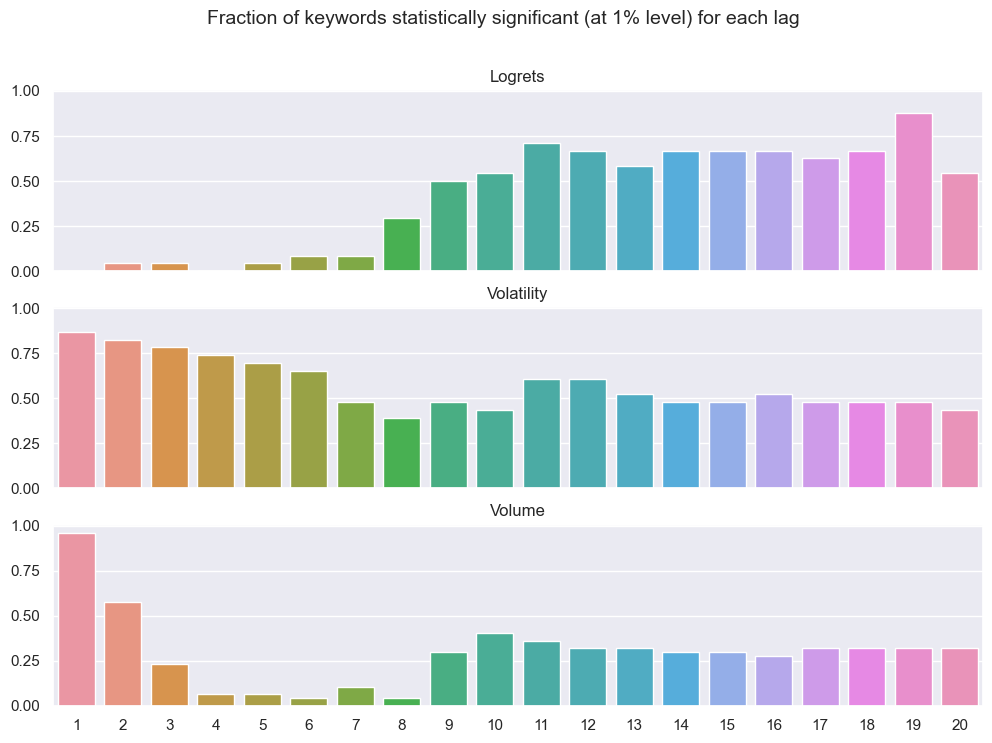

In [209]:
# ----- Number of keywords statistically significant (at 1% level) for each target and each lag -----
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True, sharey=True)
fig.suptitle("Fraction of keywords statistically significant (at 1% level) for each lag", fontsize=14)
sns.set_theme(style="whitegrid")

#Logrets
sns.barplot(x=counts_logreturns.index, y=counts_logreturns.values, ax=ax[0])
ax[0].set_title("Logrets", fontsize=12)

#Volatility
sns.barplot(x=counts_volatility.index, y=counts_volatility.values, ax=ax[1])
ax[1].set_title("Volatility", fontsize=12)

#Volume
sns.barplot(x=counts_volume.index, y=counts_volume.values, ax=ax[2])
ax[2].set_title("Volume", fontsize=12)

plt.show()

✍🏻 **Analysis** 

The first interesting observation is that a substantial fraction of keywords exhibited statistical significance in the Granger causal test for each Bitcoin indicator, after filtering out keywords with no impact at all lags.

 Key patterns emerged, with some similarities and intriguing differences across the indicators.


- For *log returns* and *volume*, establishing a Granger causal effect seems to be more challenging for certain lags. The fraction of statistically significant keywords remained low or even negligible from lag 4 to 8 for *volume* and from lag 1 to 9 for *log returns*. 

- *Volatility* and *volume* exhibit a comparable trend, showcasing a substantial proportion of statistically significant keywords during the initial lags, followed by a decline (more rapid for volume and smoother for volatility). It then increases around lag 10, to stabilize thereafter. However, the prevalence of statistically significant keywords is consistently greater for *volatility* than for *volume* across all lags, except at lag 1, where nearly all keywords successfully pass the test.

- Conversely, *log returns* exhibit a contrasting pattern, with a minimal (or even negligible) proportion of statistically significant keywords during the initial lags. Subsequently, there is a sudden increase around lag 8, followed by a stabilization around 70% (with a notable peak at lag 19). 

**Different type of effects:**

- *Short-term effect for volatility and volume:* The initial lags are characterized by a high proportion of statistically significant keywords, indicating a short-term impact of market sentiment (reflected by popularity index in Google Trends) on Bitcoin's *volatility* and *volume*. This suggests that these indicators respond swiftly to news and heightened interest in Bitcoin.

- *Delayed effect for log returns:* Conversely, market sentiment appears to have a delayed impact on Bitcoin's log returns, with a low proportion of statistically significant keywords during the initial lags. This implies that the impact of market sentiment on Bitcoin's *log returns* is not immediate, but rather occurs over a more extended period. 


Summarizing our analysis, *volatility* emerges as the most responsive indicator to market sentiment, consistently featuring a higher proportion of statistically significant keywords. *Volume* follows a similar pattern and displays heightened sensitivity to market sentiment in the short term, while *log returns* exhibit a delayed response to market sentiment.

### **Distribution of p-values for each lag**

💡 Looking at the fraction of relevant keywords in predicting Bitcoin's indicators raises one question : what about the remaining keywords? Are their p-values small or large? 

To answer this question, , we opt to visualize the distribution of p-values at each lag. This approach will provide a better idea of the impact of market sentiment on Bitcoin's indicators. 

Indeed, if, for a given lag, the distribution exhibits a small spread, indicating small p-values, it suggests that all indicators possess predictive capabilities for Bitcoin's dynamics. This implies a robust connection between market sentiment and Bitcoin's indicators, regardless of the specific keyword.

Conversely, a more dispersed distribution, with extreme p-values nearing 1, may signify challenges in establishing a direct link between market sentiment and Bitcoin's indicators. However, tracking keywords with small p-values becomes interesting in that case, as they stand out from the rest.

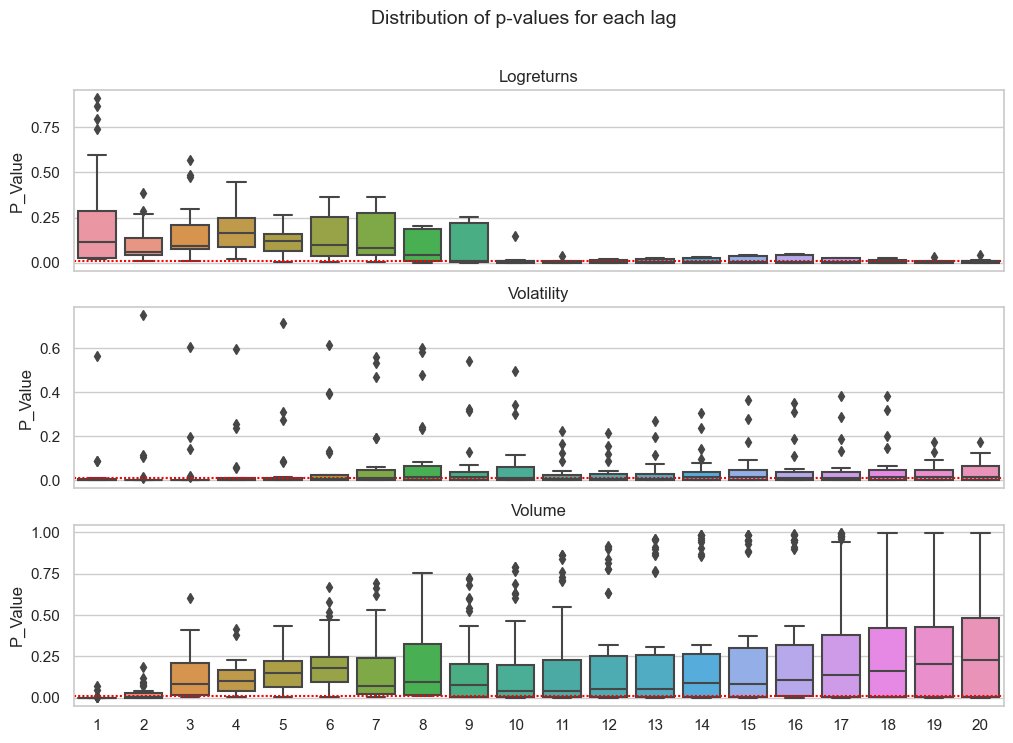

In [210]:
# ----- Distribution of p-values -----

# Melt the DataFrame to have a 'variable' column for keywords and 'value' column for p-values
melted_logreturns = pvals_logreturns.melt(var_name='Keyword', value_name='P_Value', ignore_index=False)
melted_volatility = pvals_volatility.melt(var_name='Keyword', value_name='P_Value', ignore_index=False)
melted_volume = pvals_volume.melt(var_name='Keyword', value_name='P_Value', ignore_index=False)

# Create a boxplot to visualize distribution of p-values for each lag 
fig, ax = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
fig.suptitle("Distribution of p-values for each lag", fontsize=14)
sns.set_theme(style="whitegrid")

#Logreturns
sns.boxplot(x=melted_logreturns.index, y='P_Value', data=melted_logreturns, ax = ax[0])
ax[0].axhline(0.01, color="red", dashes=(1,1))
ax[0].set_title('Logreturns', fontsize=12)

#Volatility
sns.boxplot(x=melted_volatility.index, y='P_Value', data=melted_volatility, ax = ax[1])
ax[1].axhline(0.01, color="red", dashes=(1,1))
ax[1].set_title('Volatility', fontsize=12)

#Volume
sns.boxplot(x=melted_volume.index, y='P_Value', data=melted_volume, ax = ax[2])
ax[2].axhline(0.01, color="red", dashes=(1,1))
ax[2].set_title('Volume', fontsize=12)

plt.show()

✍🏻 **Analysis** 

**Logreturns:**

- *Delayed and Stable Influence (Lag 10 and Beyond):* A significant majority of keywords demonstrate statistical significance for logreturns from lag 10 onward, with almost no outliers (high p-value). This implies a robust and enduring impact of overall market sentiment on logreturns post a 10-day period. We can also deduce that no specific keyword stands out, as the distribution of p-values is shrinked towards the mean. 

**Volatility:**   

- *A stable distribution over all lags:* The distribution of p-values for volatility is relatively stable across all lags, with no discernible pattern, confirming the high fraction of statistically significant keywords. However, the presence of numerous outliers compared to log returns suggests that some keywords are much more influential than others. 

**Volume:**

- *Much more uncertainty:* The distribution of p-values for volume introduces a nuanced perspective. The latter is much more spread out for all lags expect the two first ones. This suggests that the relationship between market sentiment and volume is less straightforward compared to the other indicators. Some keywords would yield substantial influence, while others display minimal effect.


#### **Persistence of keywords across lags**

💡We decided to check whether keywords are statistically significant across all lags, or if they are only significant for a specific lag. 

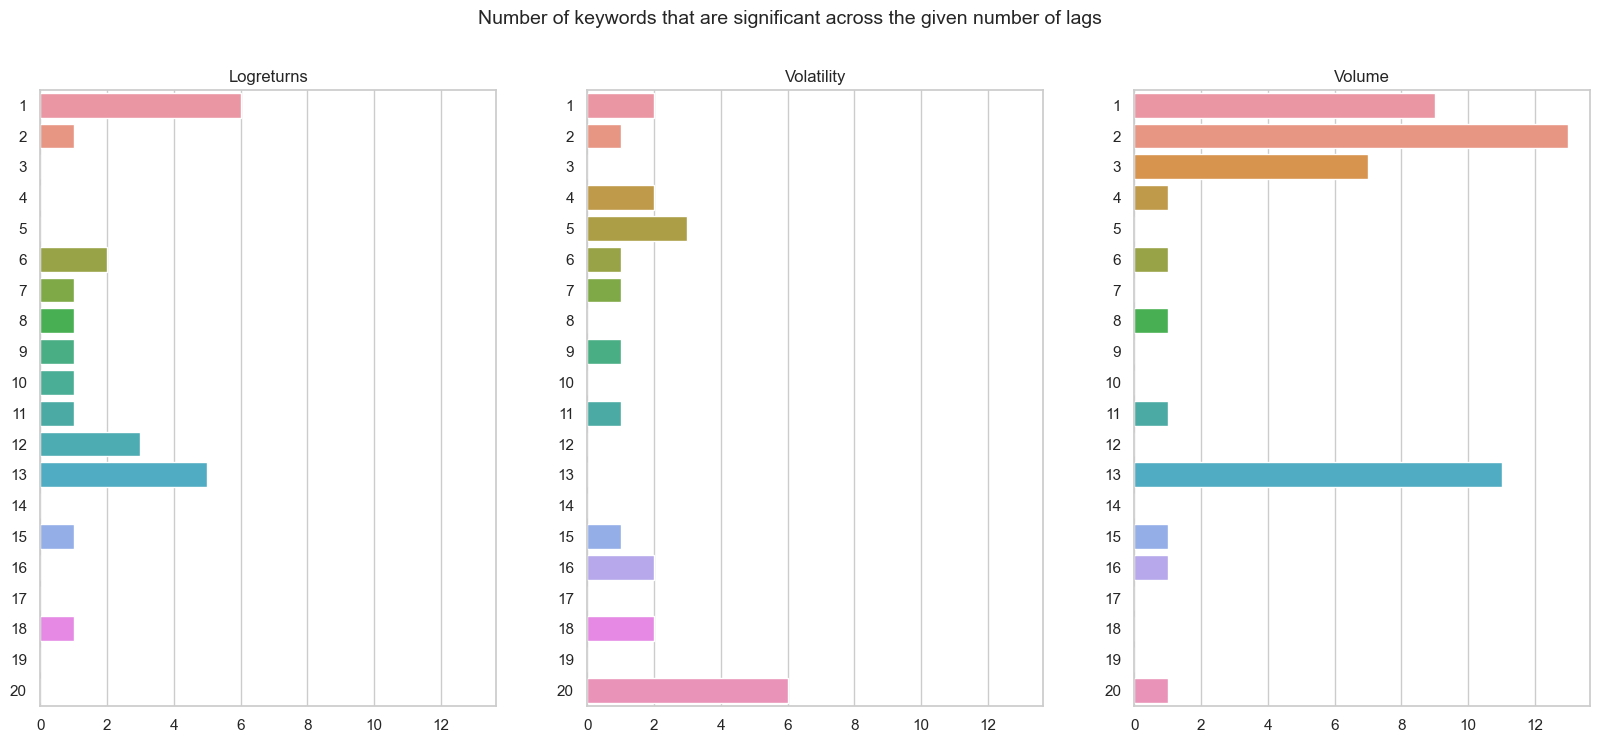

In [211]:
# ----- Number of keywords that are significant across the given number of lags -----
def lags_significant(df) : 
    counts = (df < 0.01).sum(axis=0)
    counts_df = counts.groupby(counts.values).count()

    # Ensure that all possible values are included in the index
    all_possible_values = range(1, 21)
    counts_df = counts_df.reindex(all_possible_values, fill_value=0)
    return counts_df

lags_logreturns = lags_significant(pvals_logreturns)
lags_volatility = lags_significant(pvals_volatility)
lags_volume = lags_significant(pvals_volume)

fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharex=True)
fig.suptitle("Number of keywords that are significant across the given number of lags", fontsize=14)
sns.set_theme(style="whitegrid")

sns.barplot(x=lags_logreturns.values, y=lags_logreturns.index, ax = ax[0], orient='h')
ax[0].set_title("Logreturns", fontsize=12)

sns.barplot(x=lags_volatility.values, y=lags_volatility.index, ax = ax[1], orient='h')
ax[1].set_title("Volatility", fontsize=12)

sns.barplot(x=lags_volume.values, y=lags_volume.index, ax = ax[2], orient='h')
ax[2].set_title("Volume", fontsize=12)

plt.show()

💡 Regarding the *Volume*, a significant portion of keywords exhibits statistical significance for only a limited number of lags. As a consequence, the overall number of significant keywords is higher than for the other indicators. This aligns with our earlier observation that *Volume* is characterized by increased uncertainty.

On the contrary, for *Volatility*, we observe the opposite trend, with a substantial number of keywords demonstrating significance across all lags. Despite the fluctuating fraction of significant keywords over time (highest in the early lags and diminishing later on), nearly one-third of the keywords remain significant across all lags. This suggests a robust association between these keywords and *volatility*.

In the case of *logreturns*, we observe a more balanced distribution. A significant number of keywords show statistical significance for a limited number of lags, while others maintain significance across all lags. It's noteworthy that a considerable number of keywords are linked to only one lag, indicating a more localized impact on *logreturns*.

### **Evolution of significant keywords acroos lags**

💡After having studied the overall impact of keywords on the three Bitcoin's indicators, we finally visualize the evolution of significant keywords across all lags. 

To do so, we transformed the matrix of p-values into a matrix of 0 and 1, where 1 indicates that the keyword is statistically significant for the corresponding lag. Then, we visualized the results using a heatmap.

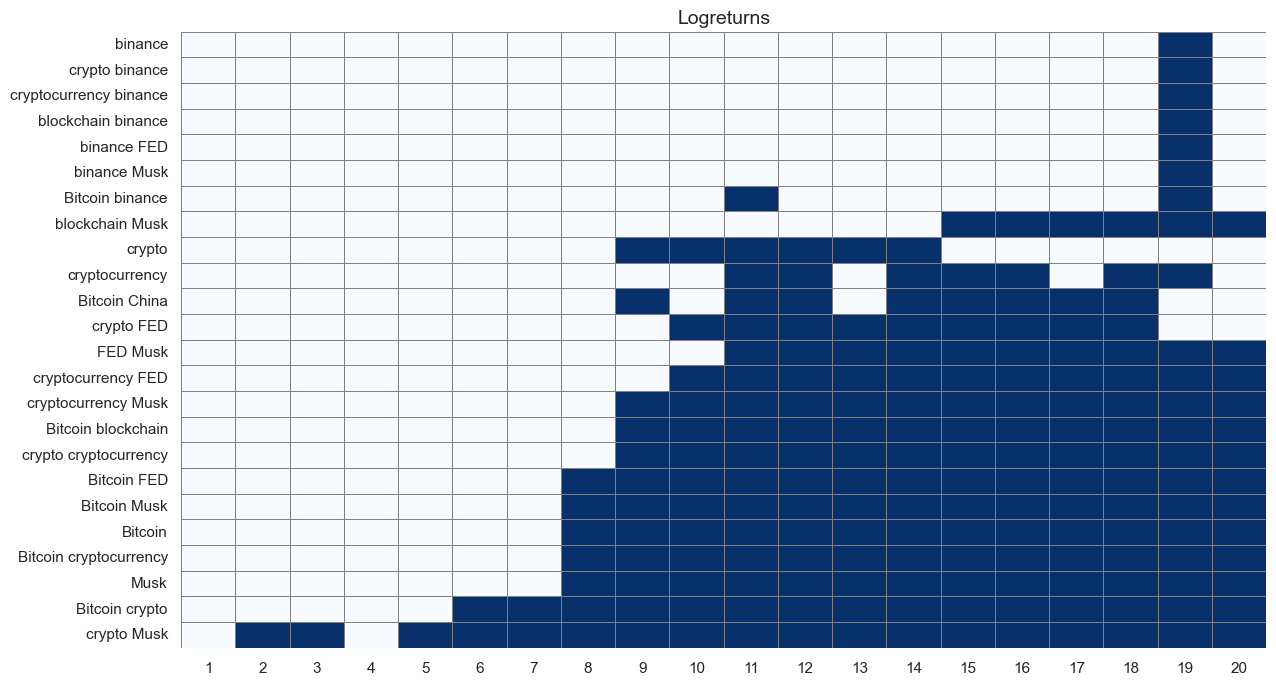

In [254]:
def plot_heatmap(df, title) :
    df = (df < 0.01).astype(int).transpose()
    df["sum"] = df.sum(axis=1)
    df.sort_values(by="sum", ascending=True, inplace=True)
    df.drop(columns=["sum"], inplace=True)
    if title == "Volume" :
        sns.set(rc={'figure.figsize':(14,14)})
    else : 
        sns.set(rc={'figure.figsize':(14,8)})
    sns.heatmap(df, cmap="Blues", linewidth=0.4, cbar=False, linecolor="grey")
    plt.title(title, fontsize=14)
    plt.show()

plot_heatmap(pvals_logreturns, "Logreturns")

 ✍🏻 A large set of keywords follow the same behavior. For instance, "Bitcoin FED", "Bitcoin Musk", "Bitcoin", "Bitcoin cryptocurrency", "Musk" are all significant between lags 8 and 20.   

One important keyword seems to be "crypto Musk". This keywords is significant at almost all lags and is the only one to have a short-term impact on logreturns. Moreover, the keyword "Musk" by itself emerges as a highly significant keyword, appearing in 29% of all combinations (7/23),  while bitcoin appears in 8 out of 24 combinations.

An interesting observation is the absence of the keywords "btc" and "trading" throughout the lags, while "FED" and "China" are present. One may associate at first sight "btc" and "trading" with Bitcoin, but it seems that they are not relevant to predict the price of Bitcoin.
In any case, this aligns with the insights from the first part of the project, which highlighted the substantial impact of China's ban and FED announcements on Bitcoin's price.  

Additionally, a noteworthy event occurs at lag 19, where keywords containing "binance" suddenly appear simultaneously.

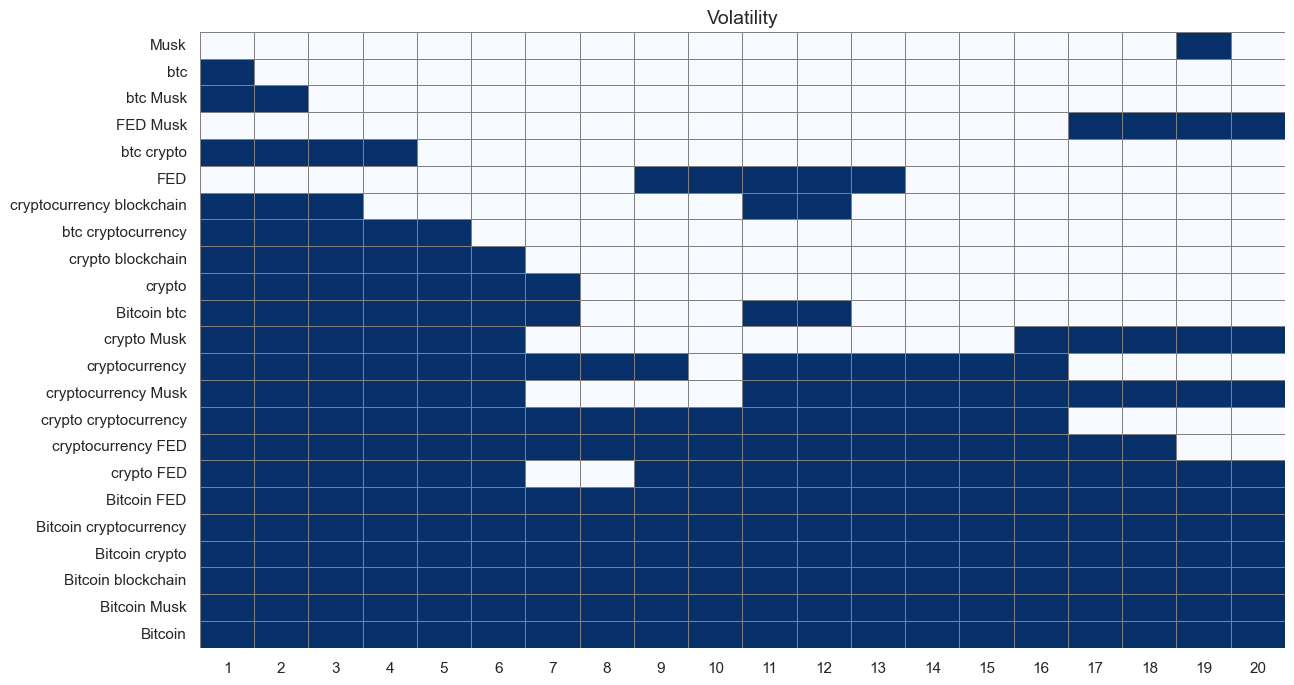

In [255]:
plot_heatmap(pvals_volatility, "Volatility")

✍🏻 Compared with logreturns, our dear "Musk" seems to have a less stable impact on volatility. Indeed, although the term "Bitcoin Musk" is significant at all lags, other terms only have an impact on a limited number of lags, such as "Musk" at lag 19 and "btc Musk" at lags 1 and 2. 

It is interesting to note that a very large number of terms are significant across all lags, as we identified earlier. This means that they are closely related to Bitcoin's volatility. These terms are: "Bitcoin FED", "Bitcoin cryptocurrency", "Bitcoin blockchain", "Bitcoin Musk" and "Bitcoin". This is the same set of words as those that were the most persistent on the logreturns, except that "Musk" which is replaced by "Bitcoin cryptocurrency". This set of words therefore seems to have a strong influence on Bitcoin's dynamics, regardless of the indicator.

Certain keywords, such as "btc", "crypto" or "cryptocurrency" appear to be more frequent than for logreturns, as we would have expected. It seems that the set of keywords is more general for volatility, with less tendency towards a particular keyword that attracts attention such as "Musk" or "binance" for logreturns.

Note also that the term "FED" is well established, with 3 bigrams strongly linked to Bitcoin's volatility: "crypto FED", "Bitcoin FED", "cryptocurrency FED".



In [258]:
len(pvals_volume.columns)

47

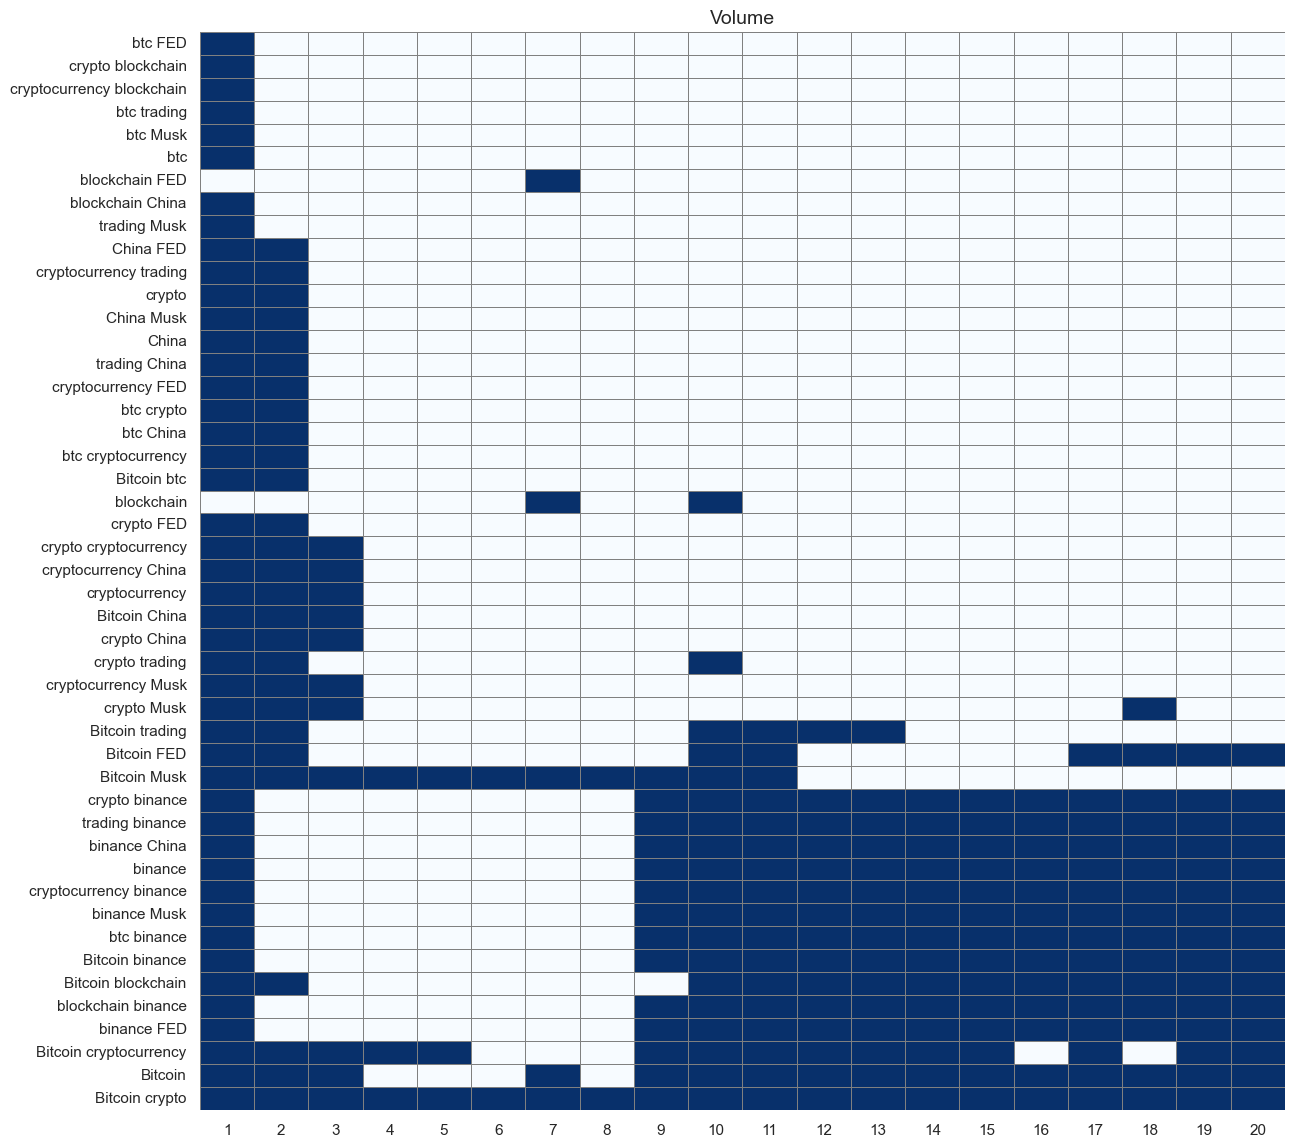

In [256]:
plot_heatmap(pvals_volume, "Volume")

✍🏻 As previously identified, the number of keywords impacting Bitcoin's volume is significantly higher than for the other two indicators.

While the majority of keywords are significant only at the first lag, it is important to note the emergence of specific keywords, a substantial proportion of which contains the term "China" (10 out of 47, or 21%). This confirms the influence of China on Bitcoin's volume, aligning with our observations from the first part of the project. "Trading" is also frequently present, appearing 5 times out of 47 (10%), in contrast to the other indicators where it was absent.

Thus, our hypothesis suggests that volume is the indicator that reacts most promptly to news and market sentiment, as reflected by the number and content of significant keywords at the first lag.

The keyword "binance" stands out by being the most frequently present in the set of significant combinations over a substantial number of lags. Examining lags 9 to 20, "binance" is included in 10 out of 12 significant combinations. It is interesting to note that combinations containing "binance" only become significant from lag 9 onward, indicating a delayed effect compared to most other keywords. These periods represent the longest phases where a set of keywords is significant for volume, with the exceptions of "Bitcoin crypto" (on all lags) and "Bitcoin cryptocurrency" (on 17 lags in total).

## **5. Mutual information**

💡 Now that we have identified a set of keywords that have a significant impact on Bitcoin's indicators, we will quantify the strength of the relationship using mutual information.

Indeed, it is hard to only use p-values to distinguish which are the most significant keywords over the different lags. That's why we will use mutual information to rank the keywords based on their significance in influencing Bitcoin's price dynamics.

Note that we will only study the set of significant keywords from last part. 

**Mutual information:** 

Mutual information is a measure of the amount of information that one random variable contains about another random variable. 

The mutual information between two random variables $X$ and $Y$ is defined as follows:

$I(X;Y) = E[\log{\frac{p(x,y)}{p(x)p(y)}}]$

where $p(x,y)$ is the joint probability distribution function of $X$ and $Y$, and $p(x)$ and $p(y)$ are the marginal probability distribution functions of $X$ and $Y$ respectively.

Given two-time series X and Y, the mutual information I(X; Y) can be used to determine the strength and direction of the relationship between X and Y, such as positive or negative dependence. A value of 0 implies the two random variables are independent.

### **Compute mutual information**

In [260]:
import sklearn 
from sklearn.feature_selection import mutual_info_regression

@dask.delayed
def mutual_information(keyword, target) :
    """ 
    Compute mutual information between keyword and the target at different lags
    """
        
    #Open file 
    dir_name = "data/clean/google_trends\\"
    df = pd.read_parquet(dir_name+keyword.replace(" ", "_"))

    #Only select the target and the keyword of interest
    df = df[[target, df.columns[-1]]]

    #Shift data to get different lags
    for lag in range(1,21) : 
        df[str(lag)] = df[df.columns[-1]].shift(lag)
    
    df.dropna(inplace=True)
    df.drop(columns=[df.columns[-1]], inplace=True)

    #Compute mutual information
    mi = mutual_info_regression(df.iloc[:,1:], df.iloc[:,0])

    #Store results in a dataframe
    mi_df = pd.DataFrame(mi, index=range(1,21), columns=[keyword])

    return mi_df


def main_mutual_information(keywords, target) :

    allpromises = [mutual_information(keyword, target) for keyword in keywords]
    alldata = dask.compute(allpromises)[0]
    data = pd.concat(alldata, axis=1)

    #Save as parquet 
    if not os.path.isdir("data/raw/google_trends/"):
        os.makedirs("data/raw/google_trends/")

    name_file = f"mutual_information_{target}.parquet"
    data.to_parquet("data/raw/google_trends/"+name_file, use_deprecated_int96_timestamps=True, compression="brotli")

    print(target, " done.")

main_mutual_information(pvals_logreturns.columns, "Logrets")
main_mutual_information(pvals_volatility.columns, "Volatility")
main_mutual_information(pvals_volume.columns, "Volume")

Logrets  done.
Volatility  done.
Volume  done.


### **Keywords with highest score**

💡 We retrieve, for each lag, the keyword with the highest mutual information score.

In [366]:
def highest_score(df) : 
    """
    Retrieve the keyword with the highest mutual information score for each lag.
    """
    lag_kw = {}
    keywords = df.columns
    for index, row in df.iterrows() :
        max_idx = row.idxmax()
        lag_kw[index] = max_idx

    df_max = pd.DataFrame.from_dict(lag_kw, orient='index', columns=["Mutual Information"])

    return df_max

mi_logreturns = pd.read_parquet("data/raw/google_trends/mutual_information_Logrets.parquet")
mi_volatility = pd.read_parquet("data/raw/google_trends/mutual_information_Volatility.parquet")
mi_volume = pd.read_parquet("data/raw/google_trends/mutual_information_Volume.parquet")

mi_logreturns_top = highest_score(mi_logreturns)
mi_volatility_top = highest_score(mi_volatility)
mi_volume_top = highest_score(mi_volume)

### **Plot mutual information for top keywords**

In [368]:
def plot_top_keywords(df, mi, title) :     
    mi_top = df[mi["Mutual Information"].values] 
    melted_mi = mi_top.melt(var_name='Keyword', value_name='MI', ignore_index=False).sort_index()
    fig = px.line(melted_mi, x=melted_mi.index, y=melted_mi.columns, color='Keyword', markers=True)
    fig.update_layout(title="Mutual Information for top keywords - " + title, xaxis_title="Lag", yaxis_title="MI", height=350, width=1000)
    fig.show()

plot_top_keywords(pvals_logreturns, mi_logreturns_top, "Logrets")
plot_top_keywords(pvals_volatility, mi_volatility_top, "Volatility")
plot_top_keywords(pvals_volume, mi_volume_top, "Volume")


❓ Small results + not same observations as before -> we keep ? 

### **Top keywords for each lag**

In [ ]:
#Fit VAR model and retrieve coefficients

from statsmodels.tsa.api import VAR

def fit_VAR_model(df, target, maxlag) :
    """
    Fit VAR model for a given target and a given number of lags.
    """
    model = VAR(df[[target]])
    results = model.fit(maxlags=maxlag, ic='aic')
    return results

💡 To finish this part, we display the top 3 keywords with the highest mutual information score for each lag.

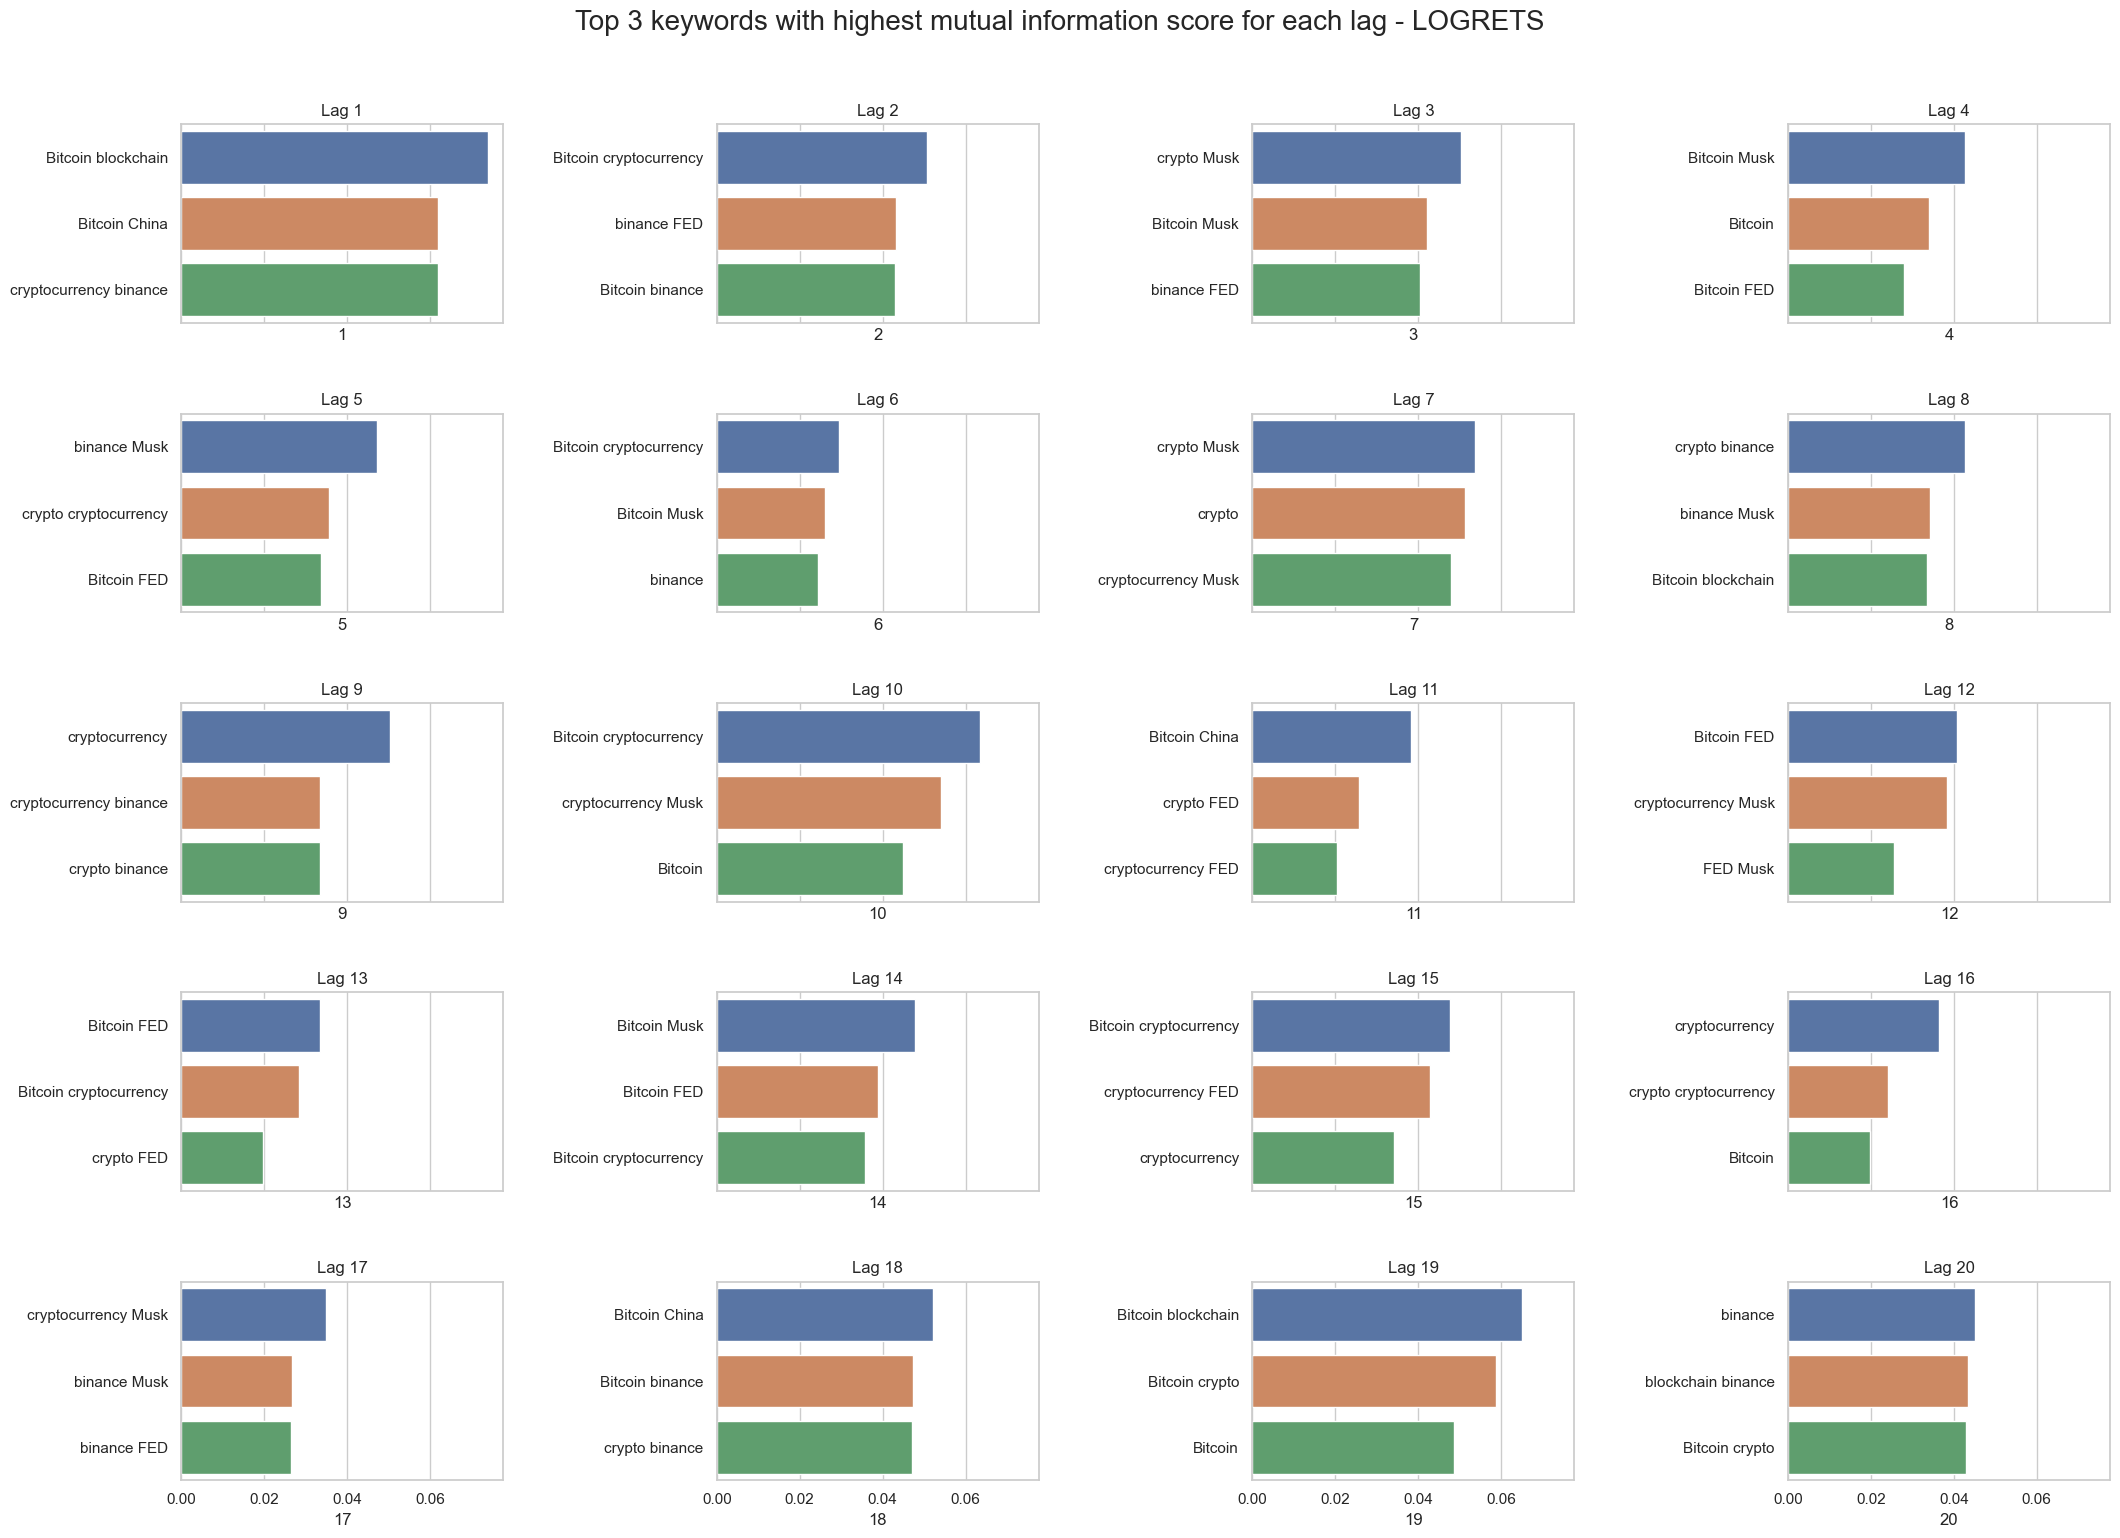

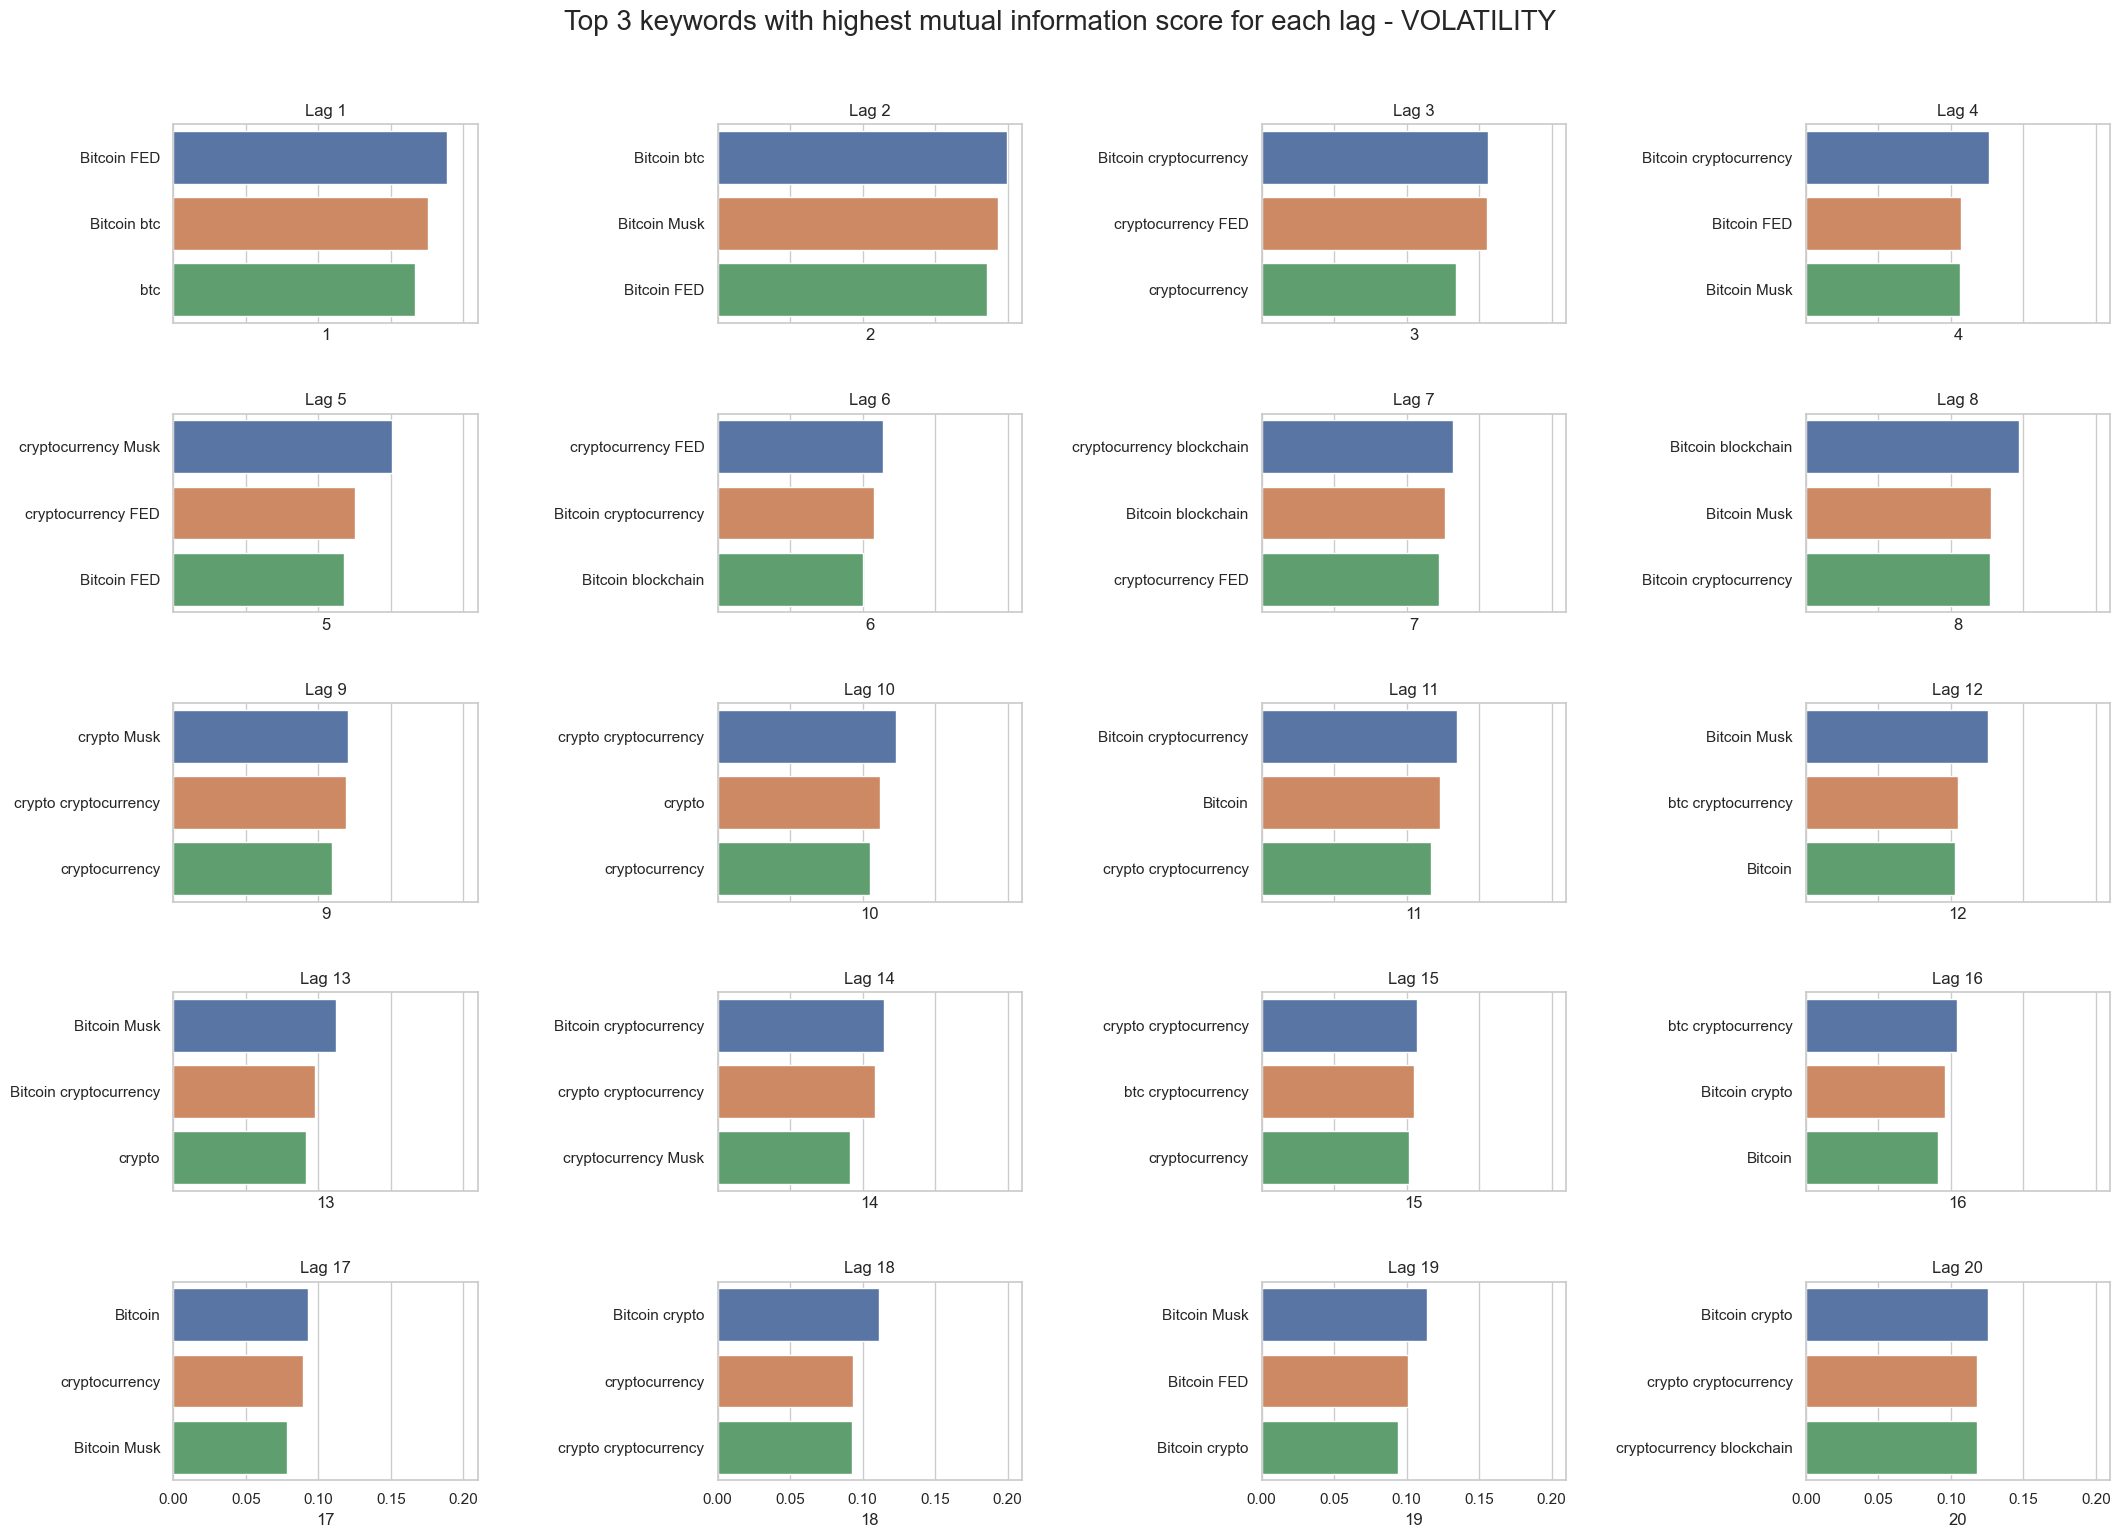

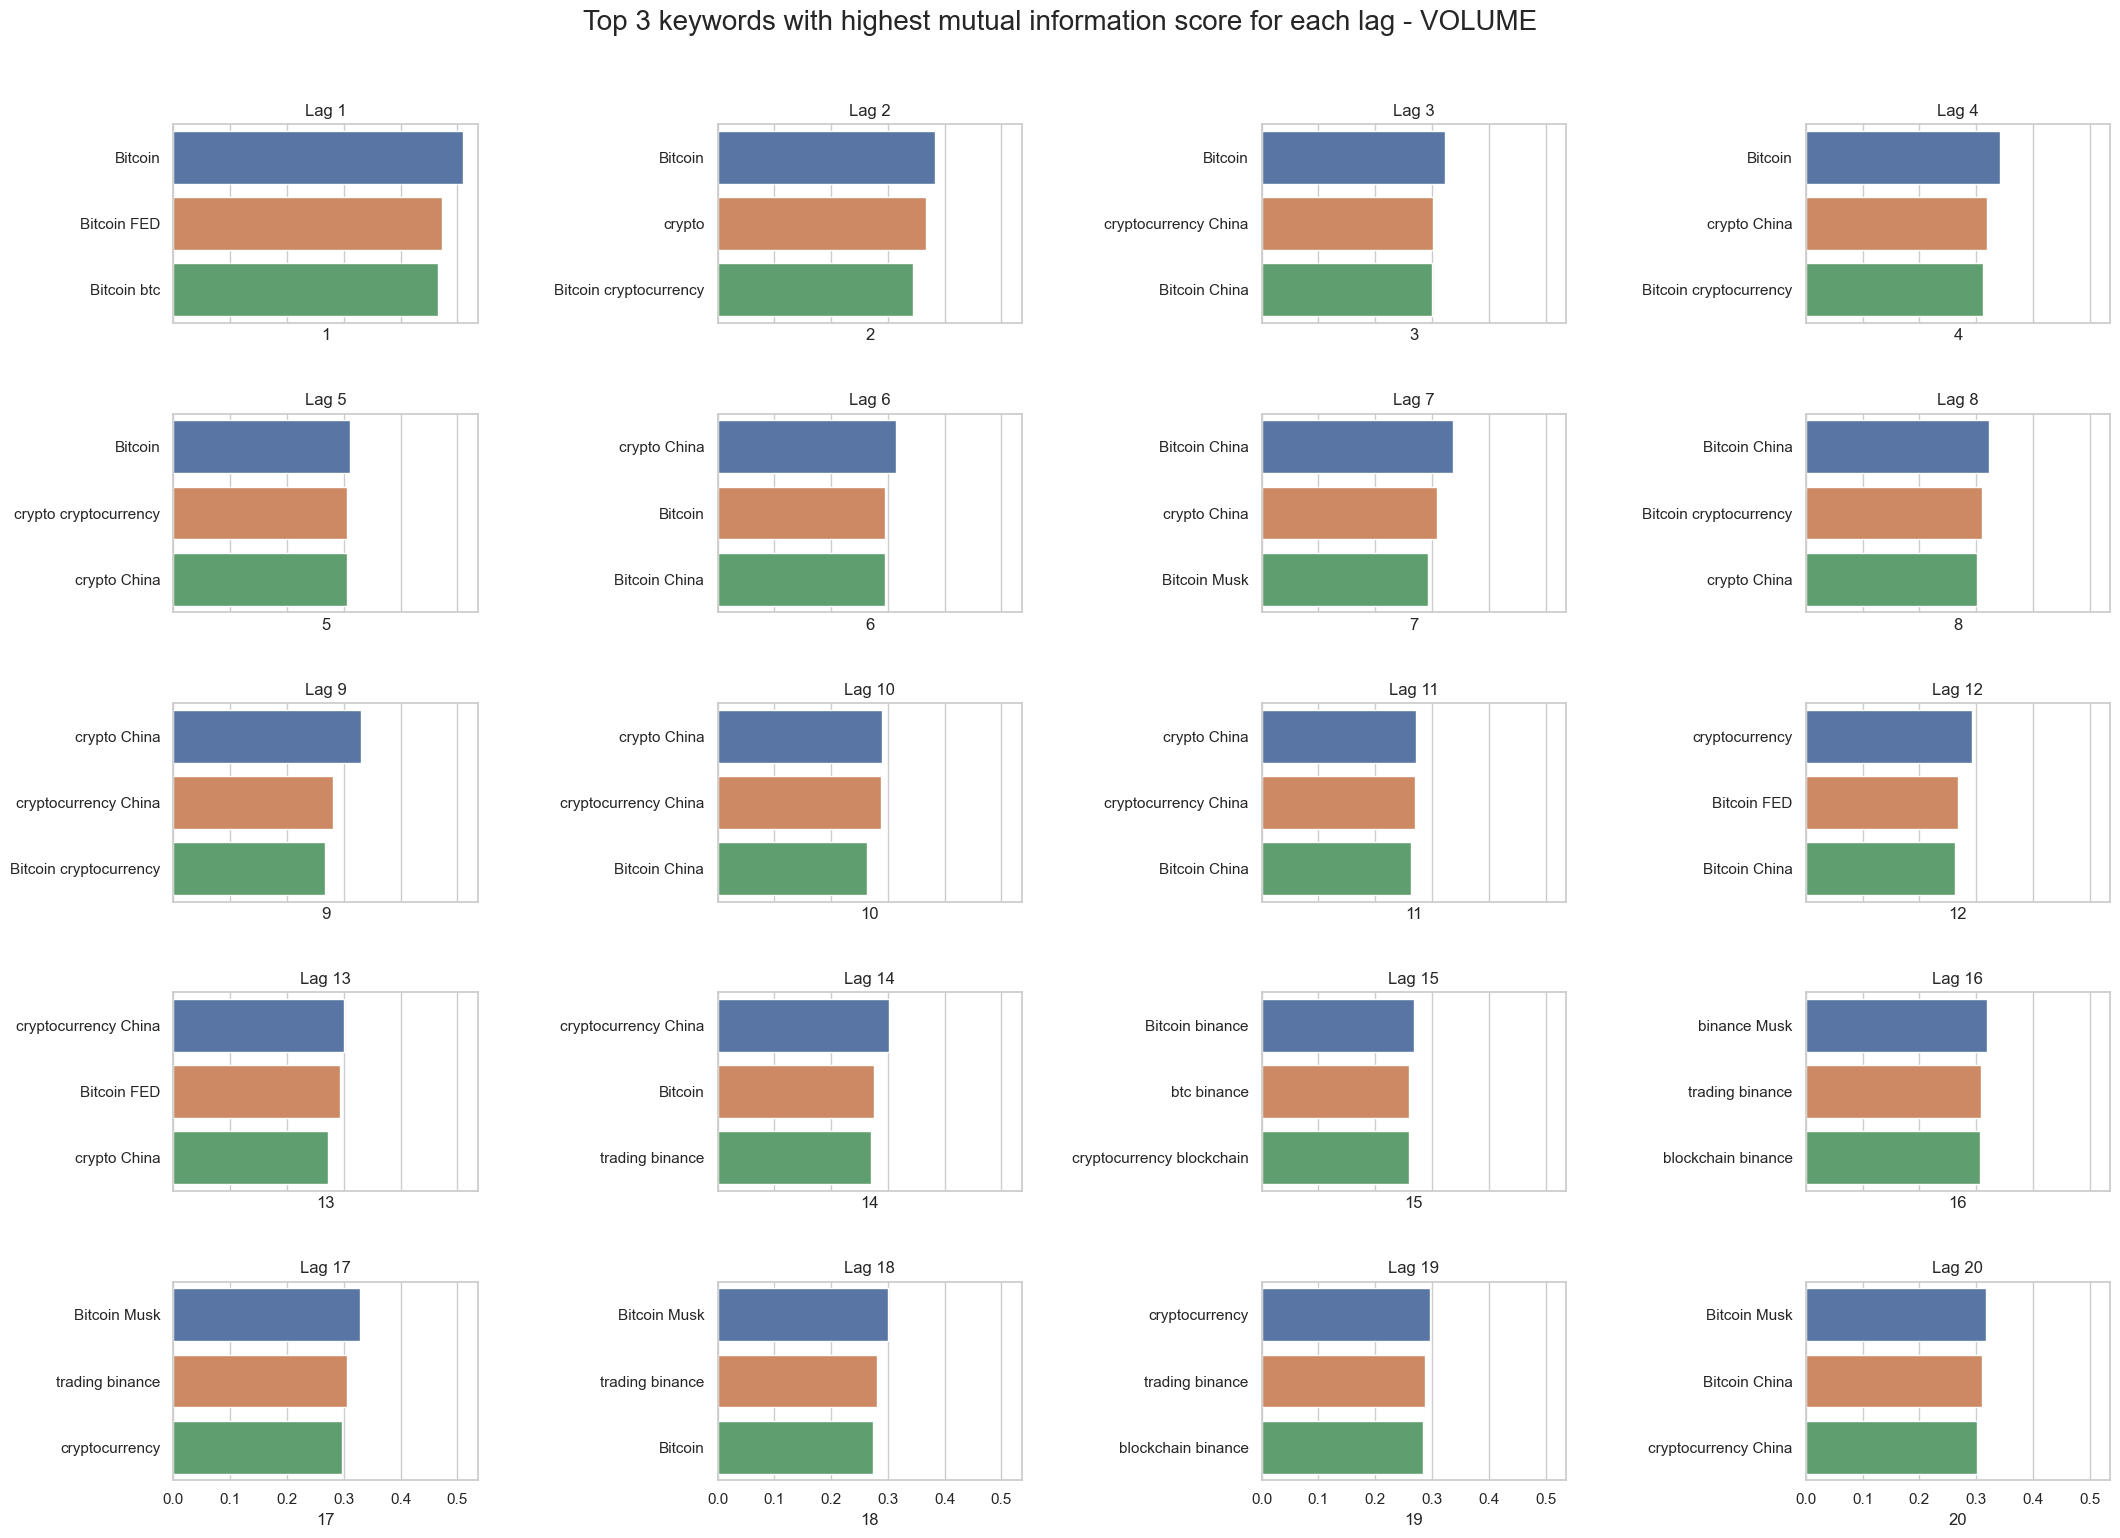

In [407]:
def top3_keywords(df, title) : 
    """
    Plot the top 3 keywords with highest mutual information score for each lag. 
    """
    #Set subplots 
    fig, ax = plt.subplots(5, 4, figsize=(22, 16), sharex=True)
    fig.suptitle("Top 3 keywords with highest mutual information score for each lag - " + title, fontsize=20)
    
    colnames = df.columns
    #For each lag
    for index, row in df.iterrows():
        #Retrieve top 3 keywords 
        top3 = colnames[row.to_numpy().argsort()[-3:][::-1]].tolist()
        
        #Plot 
        sns.barplot(x=row[top3], y=top3, ax=ax[(index-1)//4, (index-1)%4])
        ax[(index-1)//4, (index-1)%4].set_title(f"Lag {index}", fontsize=12)

    fig.tight_layout(pad=3)
    fig.show()

top3_keywords(mi_logreturns, "LOGRETS")
top3_keywords(mi_volatility, "VOLATILITY")
top3_keywords(mi_volume, "VOLUME")